In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pickle
%matplotlib inline

In [2]:
img = plt.imread('test5.jpg')
print(img.shape)

(720, 1280, 3)


In [3]:
data = pickle.load( open( "camera_calibration.p", "rb" ) )
mtx = data['mtx']
dist = data['dist']

(720, 1280, 3)


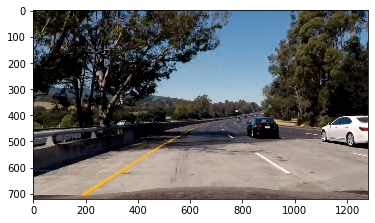

In [4]:
dst = cv2.undistort(img, mtx, dist, None, mtx)
print(dst.shape)
plt.imshow(dst)

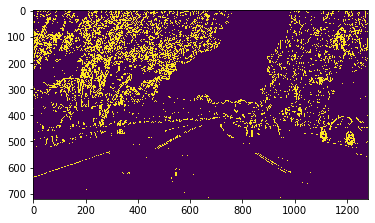

In [134]:
# Thresholding by sobel
# First Gradient absolute value
# Second Gradient magnitude.
# Third Gradient absolute value

def gradient_abs_value_mask(image, orient='x',sobel_kernel=3, threshold=(0, 255)):
    """
    Masks the image based on gradient absolute value.
    Parameters
    ----------
    image           : Image to mask.
    sobel_kernel    : Kernel of the Sobel gradient operation.
    axis            : Axis of the gradient, 'x' or 'y'.
    threshold       : Value threshold for it to make it to appear in the mask.
    Returns
    -------
    Image mask with 1s in activations and 0 in other pixels.
    """
    
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # We will use sobel y
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1))
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1

    return binary_output

def gradient_magnitude_mask(image, sobel_kernel=3, threshold=(0, 255)):
    """
    Masks the image based on gradient magnitude.
    Parameters
    ----------
    image           : Image to mask.
    sobel_kernel    : Kernel of the Sobel gradient operation.
    threshold       : Magnitude threshold for it to make it to appear in the mask.
    Returns
    -------
    Image mask with 1s in activations and 0 in other pixels.
    """
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude
    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    magnitude = (magnitude * 255 / np.max(magnitude)).astype(np.uint8)
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(magnitude)
    binary_output[(magnitude >= threshold[0]) & (magnitude <= threshold[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

def gradient_direction_mask(image, sobel_kernel=3, threshold=(0, np.pi / 2)):
    """
    Masks the image based on gradient direction.
    Parameters
    ----------
    image           : Image to mask.
    sobel_kernel    : Kernel of the Sobel gradient operation.
    threshold       : Direction threshold for it to make it to appear in the mask.
    Returns
    -------
    Image mask with 1s in activations and 0 in other pixels.
    """
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients and calculate the direction of the gradient
    direction = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    # Return this mask as your binary_output image
    binary_output[(direction >= threshold[0]) & (direction <= threshold[1])] = 1
    return binary_output

def apply_threshold(image,ksize=3):
    gradx = gradient_abs_value_mask(image, orient='x', sobel_kernel=ksize, threshold=(20, 255))
#     grady = gradient_abs_value_mask(image, orient='y', sobel_kernel=ksize, threshold=(20, 120))
    mag_binary = gradient_magnitude_mask(image, sobel_kernel=ksize, threshold=(50,255))
    dir_binary = gradient_direction_mask(image, sobel_kernel=15, threshold=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1))| ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

combined = apply_threshold(dst)
plt.imshow(combined)

In [135]:
# Color Threshold
def hls_thresh(image, threshold=(170, 255)):
    """
    Convert RGB to HLS and threshold to binary image using S channel
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= threshold[0]) & (s_channel <= threshold[1])] = 1
    return binary_output

s_binary = hls_thresh(dst)

In [136]:
def combine_threshold(s_binary, combined):
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1

    return combined_binary

combined_binary = combine_threshold(s_binary, combined)

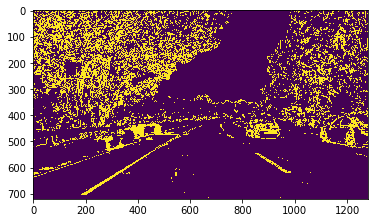

In [137]:
plt.imshow(combined_binary)

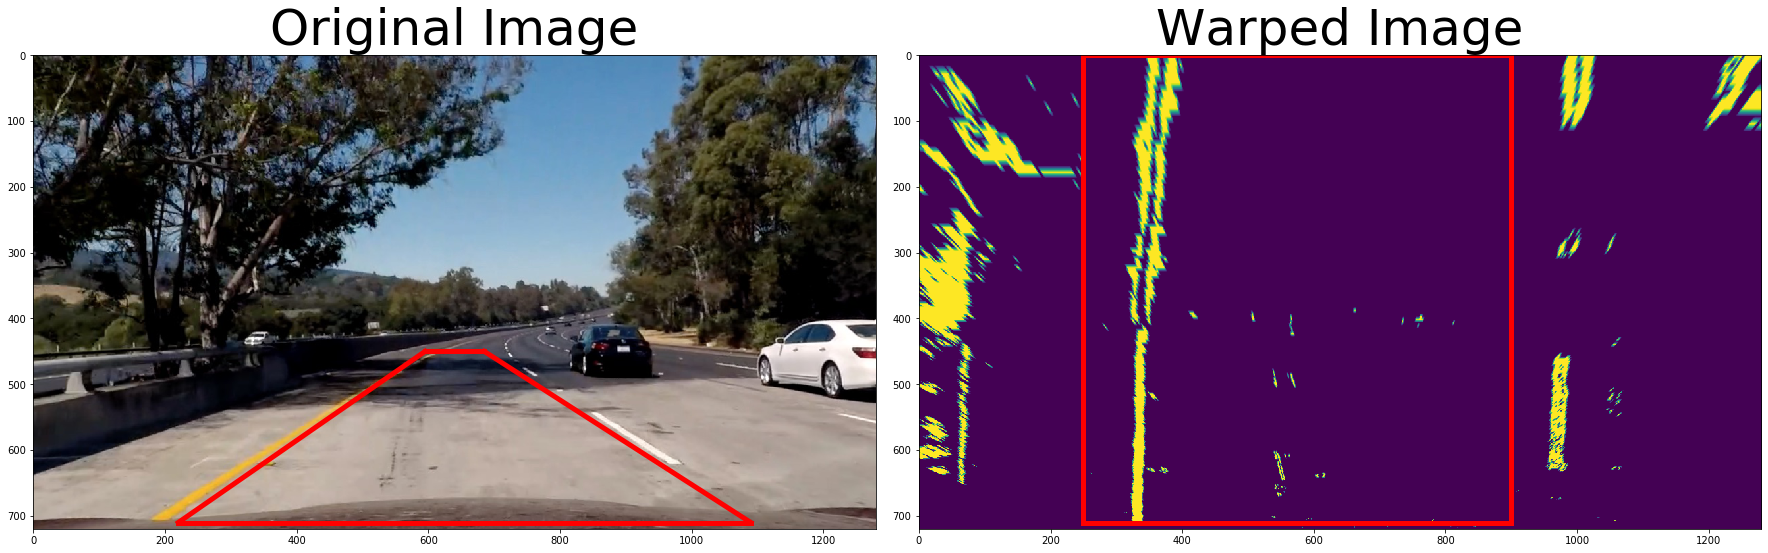

In [138]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    x = img.shape[1]
    y = img.shape[0]
    
#     src = np.float32(
#         [[704, 453],
#           [1280, 720],
#           [0, 710],
#           [576, 453]])

#     dst = np.float32(
#         [[960, 0],
#           [960, 720],
#           [320, 720],
#           [320, 0]])

    src = np.float32([
    [0.117 * x, y],
    [(0.5 * x) - (x*0.078), (2/3)*y],
    [(0.5 * x) + (x*0.078), (2/3)*y],
    [x - (0.117 * x), y]
    ])
    dst = np.float32([
    [0.25 * x, y],
    [0.25 * x, 0],
    [x - (0.25 * x), 0],
    [x - (0.25 * x), y]
    ])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    binary_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return binary_warped, Minv

def compare_plotted_images(image1, image2, image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.plot([685, 1090], [450, 710], color='r', linewidth="5")
    ax1.plot([1090, 220], [710, 710], color='r', linewidth="5")
    ax1.plot([220, 595], [710, 450], color='r', linewidth="5")
    ax1.plot([595, 685], [450, 450], color='r', linewidth="5")
    ax1.set_title(image1_exp, fontsize=50)
    ax2.imshow(image2)
    ax2.plot([900, 900], [0, 710], color='r', linewidth="5")
    ax2.plot([900, 250], [710, 710], color='r', linewidth="5")
    ax2.plot([250, 250], [710, 0], color='r', linewidth="5")
    ax2.plot([250, 900], [0, 0], color='r', linewidth="5")
    ax2.set_title(image2_exp, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


warped, Minv = warp(combined_binary)
compare_plotted_images(dst, warped, "Original Image", "Warped Image")


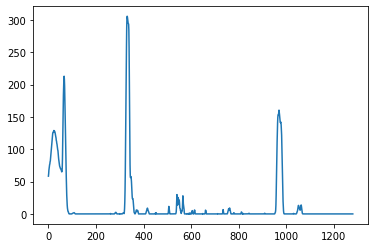

In [139]:
# Histogram
def get_histogram(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    return histogram

binary_warped, Minv = warp(dst)
histogram = get_histogram(warped)
plt.plot(histogram)

In [140]:
#Sliding Window
def slide_window(binary_warped, histogram):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Visualization Finding the lines
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate x and y values for plotting
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

    return ploty, left_fit, right_fit

In [141]:
ploty, left_fit, right_fit = slide_window(warped, histogram)

In [142]:
def skip_sliding_window(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +
    left_fit[1]*nonzeroy + left_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) +
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    ################################
    ## Visualization
    ################################

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

#     plt.imshow(result)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

    ret = {}
    ret['leftx'] = leftx
    ret['rightx'] = rightx
    ret['left_fitx'] = left_fitx
    ret['right_fitx'] = right_fitx
    ret['ploty'] = ploty

    return ret

draw_info = skip_sliding_window(warped, left_fit, right_fit)

In [143]:
def measure_curvature(ploty, lines_info):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700

    leftx = lines_info['left_fitx']
    rightx = lines_info['right_fitx']

    leftx = leftx[::-1]  
    rightx = rightx[::-1]  

    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    print(left_curverad, 'm', right_curverad, 'm')

    return left_curverad, right_curverad

left_curverad, right_curverad = measure_curvature(ploty, draw_info)

1902.9945018156673 m 1850.558888621198 m


In [144]:
def draw_lane_lines(img, warped_image, Minv, draw_info):
    leftx = draw_info['leftx']
    rightx = draw_info['rightx']
    left_fitx = draw_info['left_fitx']
    right_fitx = draw_info['right_fitx']
    ploty = draw_info['ploty']

    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    

    return result

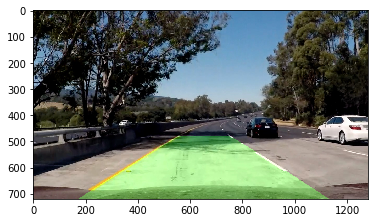

In [145]:

result = draw_lane_lines(img, warped, Minv, draw_info)
plt.imshow(result)

In [146]:
global used_warped
global used_ret

def process_image(image):
    global used_warped
    global used_ret

    # Load Pickle
    data = pickle.load( open( "camera_calibration.p", "rb" ) )
    mtx = data['mtx']
    dist = data['dist']
    
    # Undistortion 
    dst = cv2.undistort(image, mtx, dist, None, mtx)

    # Gradient thresholding
    gradient_combined = apply_threshold(dst)

    # Color thresholding
    s_binary = hls_thresh(dst)

    # Combine Gradient and Color thresholding
    combined_binary = combine_threshold(s_binary, gradient_combined)

    # Transforming Perspective
    binary_warped, Minv = warp(combined_binary)

    # Getting Histogram
    histogram = get_histogram(binary_warped)
    
    # Sliding Window to detect lane lines
    ploty, left_fit, right_fit = slide_window(binary_warped, histogram)
 
    # Skipping Sliding Window
    ret = skip_sliding_window(binary_warped, left_fit, right_fit)

    # Measuring Curvature
    left_curverad, right_curverad = measure_curvature(ploty, ret)

     # Sanity check: whether the lines are roughly parallel and have similar curvature
    slope_left = ret['left_fitx'][0] - ret['left_fitx'][-1]
    slope_right = ret['right_fitx'][0] - ret['right_fitx'][-1]
    slope_diff = abs(slope_left - slope_right)
    slope_threshold = 150
    curve_diff = abs(left_curverad - right_curverad)
    curve_threshold = 10000

    if (slope_diff > slope_threshold or curve_diff > curve_threshold):
        binary_warped = used_warped
        ret = used_ret

    # Visualizing Lane Lines Info
    result = draw_lane_lines(image, binary_warped, Minv, ret)
    
    # Annotating curvature
    fontType = cv2.FONT_HERSHEY_SIMPLEX
    curvature_text = 'The radius of curvature = ' + str(round(left_curverad, 3)) + 'm'
    cv2.putText(result, curvature_text, (30, 60), fontType, 1.5, (255, 255, 255), 3)

    # Annotating deviation
    deviation_pixels = image.shape[1]/2 - abs(ret['right_fitx'][-1] - ret['left_fitx'][-1])
    xm_per_pix = 3.7/700
    deviation = deviation_pixels * xm_per_pix
    direction = "left" if deviation < 0 else "right"
    deviation_text = 'Vehicle is ' + str(round(abs(deviation), 3)) + 'm ' + direction + ' of center'
    cv2.putText(result, deviation_text, (30, 110), fontType, 1.5, (255, 255, 255), 3)

    used_warped = binary_warped
    used_ret = ret

    return result


1902.9945018156673 m 1850.558888621198 m


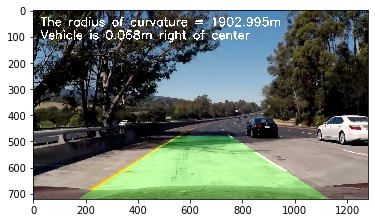

In [147]:
img = plt.imread('test5.jpg')
result_image = process_image(img)
plt.imshow(result_image)

In [148]:
import imageio
# imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [150]:
output = 'result.mp4'
clip = VideoFileClip("challenge_video.mp4")
video_clip = clip.fl_image(process_image)
%time video_clip.write_videofile(output, audio=False)

t:   0%|                                                                             | 0/485 [00:00<?, ?it/s, now=None]

1133.1897913990588 m 1591.0836623978912 m
Moviepy - Building video result.mp4.
Moviepy - Writing video result.mp4



t:   0%|▎                                                                    | 2/485 [00:00<02:07,  3.78it/s, now=None]

1133.1897913990588 m 1591.0836623978912 m


t:   1%|▍                                                                    | 3/485 [00:01<02:46,  2.90it/s, now=None]

1308.9005399796802 m 1555.7143269631297 m


t:   1%|▌                                                                    | 4/485 [00:01<03:11,  2.51it/s, now=None]

1149.5294244480192 m 2051.188495061534 m


t:   1%|▋                                                                    | 5/485 [00:02<03:29,  2.29it/s, now=None]

1192.793368754363 m 2277.8176725598255 m


t:   1%|▊                                                                    | 6/485 [00:02<03:43,  2.15it/s, now=None]

1560.983761870346 m 2466.5990194400783 m


t:   1%|▉                                                                    | 7/485 [00:03<03:54,  2.04it/s, now=None]

1351.630395064295 m 2140.487374590239 m


t:   2%|█▏                                                                   | 8/485 [00:03<03:54,  2.03it/s, now=None]

1376.5133249893122 m 2539.2531380552273 m


t:   2%|█▎                                                                   | 9/485 [00:04<03:53,  2.04it/s, now=None]

1527.8105441360283 m 1669.5966243447356 m


t:   2%|█▍                                                                  | 10/485 [00:04<03:59,  1.98it/s, now=None]

1666.7139819797248 m 1511.1141673102616 m


t:   2%|█▌                                                                  | 11/485 [00:05<03:59,  1.98it/s, now=None]

1519.745899176215 m 1094.5553867856247 m


t:   2%|█▋                                                                  | 12/485 [00:05<03:58,  1.98it/s, now=None]

1347.3600207555273 m 1151.2293546805606 m


t:   3%|█▊                                                                  | 13/485 [00:06<04:04,  1.93it/s, now=None]

1436.7063303162959 m 1075.1682196489462 m


t:   3%|█▉                                                                  | 14/485 [00:06<04:09,  1.89it/s, now=None]

1605.6860773225796 m 1051.000916483723 m


t:   3%|██                                                                  | 15/485 [00:07<04:06,  1.90it/s, now=None]

1423.771232004159 m 1013.5759760808479 m


t:   3%|██▏                                                                 | 16/485 [00:07<04:09,  1.88it/s, now=None]

1315.4753979322707 m 922.497996501393 m


t:   4%|██▍                                                                 | 17/485 [00:08<04:06,  1.90it/s, now=None]

1345.9823695471503 m 820.4626850688925 m


t:   4%|██▌                                                                 | 18/485 [00:08<04:03,  1.92it/s, now=None]

1345.6049220780242 m 879.3001559260856 m


t:   4%|██▋                                                                 | 19/485 [00:09<03:57,  1.96it/s, now=None]

1608.5664686303508 m 1503.1079233755336 m


t:   4%|██▊                                                                 | 20/485 [00:09<03:58,  1.95it/s, now=None]

1242.3893254133657 m 2789.657394099182 m


t:   4%|██▉                                                                 | 21/485 [00:10<03:59,  1.94it/s, now=None]

1475.1110800836016 m 2698.4461893212565 m


t:   5%|███                                                                 | 22/485 [00:10<03:57,  1.95it/s, now=None]

628.435000340163 m 6382.807200523352 m


t:   5%|███▏                                                                | 23/485 [00:11<03:55,  1.96it/s, now=None]

888.5318587933929 m 5138.185058925227 m


t:   5%|███▎                                                                | 24/485 [00:11<03:58,  1.94it/s, now=None]

607.2900577288345 m 24826.287725204962 m


t:   5%|███▌                                                                | 25/485 [00:12<03:53,  1.97it/s, now=None]

800.5726026818493 m 1924.470599636717 m


t:   5%|███▋                                                                | 26/485 [00:13<03:58,  1.93it/s, now=None]

735.5083086340879 m 1271.036909209719 m


t:   6%|███▊                                                                | 27/485 [00:13<03:55,  1.94it/s, now=None]

644.6239257360814 m 769.6456922998738 m


t:   6%|███▉                                                                | 28/485 [00:14<03:51,  1.97it/s, now=None]

1198.4014660806447 m 725.0115686474654 m


t:   6%|████                                                                | 29/485 [00:14<04:00,  1.90it/s, now=None]

985.8401144449485 m 626.874910054203 m


t:   6%|████▏                                                               | 30/485 [00:15<03:55,  1.93it/s, now=None]

1260.3536260359779 m 673.9275838853534 m


t:   6%|████▎                                                               | 31/485 [00:15<04:02,  1.87it/s, now=None]

1291.5549130821794 m 853.9677516982282 m


t:   7%|████▍                                                               | 32/485 [00:16<03:56,  1.91it/s, now=None]

640.6831141114717 m 727.8345447868448 m


t:   7%|████▋                                                               | 33/485 [00:16<03:50,  1.96it/s, now=None]

588.9506744927977 m 684.4139599229427 m


t:   7%|████▊                                                               | 34/485 [00:17<03:45,  2.00it/s, now=None]

765.543652000319 m 615.5297895692302 m


t:   7%|████▉                                                               | 35/485 [00:17<03:42,  2.02it/s, now=None]

509.2763028170357 m 537.3053347228567 m


t:   7%|█████                                                               | 36/485 [00:18<03:39,  2.04it/s, now=None]

442.6073512474961 m 427.7751638330352 m


t:   8%|█████▏                                                              | 37/485 [00:18<03:36,  2.07it/s, now=None]

498.9645704249561 m 360.916813419762 m


t:   8%|█████▎                                                              | 38/485 [00:19<03:38,  2.05it/s, now=None]

439.20878481394624 m 348.24380924553213 m


t:   8%|█████▍                                                              | 39/485 [00:19<03:39,  2.03it/s, now=None]

441.5738799329461 m 379.18219313206646 m


t:   8%|█████▌                                                              | 40/485 [00:20<03:44,  1.99it/s, now=None]

429.3476553222223 m 439.0279067729295 m


t:   8%|█████▋                                                              | 41/485 [00:20<03:43,  1.99it/s, now=None]

516.0747330735586 m 516.8008657448743 m


t:   9%|█████▉                                                              | 42/485 [00:21<03:40,  2.01it/s, now=None]

463.9454877605887 m 622.1059096072914 m


t:   9%|██████                                                              | 43/485 [00:21<03:46,  1.95it/s, now=None]

467.48619174048247 m 1161.715617707855 m


t:   9%|██████▏                                                             | 44/485 [00:22<04:03,  1.81it/s, now=None]

529.1993934903742 m 5793.586636112318 m


t:   9%|██████▎                                                             | 45/485 [00:22<03:55,  1.87it/s, now=None]

522.7287792592224 m 2636.6973148260226 m


t:   9%|██████▍                                                             | 46/485 [00:23<04:00,  1.82it/s, now=None]

1115.9494360743602 m 1216.9746798954482 m


t:  10%|██████▌                                                             | 47/485 [00:23<03:56,  1.85it/s, now=None]

1334.5502660859675 m 1237.1712302470753 m


t:  10%|██████▋                                                             | 48/485 [00:24<03:50,  1.90it/s, now=None]

2328.192858939817 m 4053.657031928111 m


t:  10%|██████▊                                                             | 49/485 [00:24<03:50,  1.90it/s, now=None]

1457.7342182832565 m 1756.8018594867087 m


t:  10%|███████                                                             | 50/485 [00:25<03:51,  1.88it/s, now=None]

157.41004880234655 m 1579.5900412617627 m


t:  11%|███████▏                                                            | 51/485 [00:25<03:52,  1.87it/s, now=None]

1334.6287331234105 m 1739.6537279275972 m


t:  11%|███████▎                                                            | 52/485 [00:26<03:48,  1.90it/s, now=None]

137.2903093850371 m 1458.24812809245 m


t:  11%|███████▍                                                            | 53/485 [00:26<03:47,  1.90it/s, now=None]

138.8606678765775 m 1526.9131444898337 m


t:  11%|███████▌                                                            | 54/485 [00:27<03:40,  1.95it/s, now=None]

1169.6460685700151 m 1594.016220675387 m


t:  11%|███████▋                                                            | 55/485 [00:27<03:35,  2.00it/s, now=None]

168.64499034785024 m 1286.5085917593312 m


t:  12%|███████▊                                                            | 56/485 [00:28<03:35,  1.99it/s, now=None]

171.4768417373891 m 1282.2668506044101 m


t:  12%|███████▉                                                            | 57/485 [00:28<03:36,  1.98it/s, now=None]

1300.7217862692914 m 1198.501609435887 m


t:  12%|████████▏                                                           | 58/485 [00:29<03:33,  2.00it/s, now=None]

1471.3725694249194 m 1069.892213725646 m


t:  12%|████████▎                                                           | 59/485 [00:29<03:29,  2.03it/s, now=None]

200.56810735943995 m 1059.5259356623048 m


t:  12%|████████▍                                                           | 60/485 [00:30<03:29,  2.03it/s, now=None]

325.34668568133577 m 1275.0737360243716 m


t:  13%|████████▌                                                           | 61/485 [00:30<03:30,  2.02it/s, now=None]

270.5287581215284 m 3207.2709405542364 m


t:  13%|████████▋                                                           | 62/485 [00:31<03:28,  2.03it/s, now=None]

1531.9607995443275 m 40968.88154050814 m


t:  13%|████████▊                                                           | 63/485 [00:31<03:25,  2.05it/s, now=None]

1743.6870280225417 m 5667.845434480745 m


t:  13%|████████▉                                                           | 64/485 [00:32<03:25,  2.05it/s, now=None]

2771.5669220781388 m 3956.2043724257455 m


t:  13%|█████████                                                           | 65/485 [00:32<03:24,  2.05it/s, now=None]

3752.059395894876 m 266570.8282619294 m


t:  14%|█████████▎                                                          | 66/485 [00:33<03:26,  2.02it/s, now=None]

6913.600699772857 m 1932.626786978845 m


t:  14%|█████████▍                                                          | 67/485 [00:33<03:27,  2.01it/s, now=None]

832.5709018708316 m 1480.213298577829 m


t:  14%|█████████▌                                                          | 68/485 [00:34<03:33,  1.96it/s, now=None]

1232.8725724560293 m 7842.743382764993 m


t:  14%|█████████▋                                                          | 69/485 [00:34<03:33,  1.95it/s, now=None]

1208.3857160180492 m 2789.133165068228 m


t:  14%|█████████▊                                                          | 70/485 [00:35<03:33,  1.94it/s, now=None]

1148.0916734674267 m 1266.429506260198 m


t:  15%|█████████▉                                                          | 71/485 [00:35<03:35,  1.92it/s, now=None]

1050.9950348937036 m 3045.613975084169 m


t:  15%|██████████                                                          | 72/485 [00:36<04:01,  1.71it/s, now=None]

1341.646872316527 m 1231.271336437242 m


t:  15%|██████████▏                                                         | 73/485 [00:37<04:01,  1.70it/s, now=None]

1601.8377184289047 m 1803.196598676223 m


t:  15%|██████████▍                                                         | 74/485 [00:37<03:53,  1.76it/s, now=None]

1209.9017871194671 m 2455.4982963100774 m


t:  15%|██████████▌                                                         | 75/485 [00:38<04:01,  1.70it/s, now=None]

1065.162975641696 m 1744.4404803413672 m


t:  16%|██████████▋                                                         | 76/485 [00:38<03:53,  1.75it/s, now=None]

833.274375513176 m 1026.2763634278615 m


t:  16%|██████████▊                                                         | 77/485 [00:39<03:54,  1.74it/s, now=None]

726.0579031250261 m 833.3856875418055 m


t:  16%|██████████▉                                                         | 78/485 [00:40<03:52,  1.75it/s, now=None]

637.3386803876168 m 671.1830026177838 m


t:  16%|███████████                                                         | 79/485 [00:40<03:51,  1.75it/s, now=None]

743.605222179024 m 577.1539881220209 m


t:  16%|███████████▏                                                        | 80/485 [00:41<03:47,  1.78it/s, now=None]

751.8397537662812 m 458.3646930255857 m


t:  17%|███████████▎                                                        | 81/485 [00:41<03:44,  1.80it/s, now=None]

788.9689296721591 m 377.09963467099305 m


t:  17%|███████████▍                                                        | 82/485 [00:42<03:36,  1.86it/s, now=None]

730.0052792077802 m 326.0394914621796 m


t:  17%|███████████▋                                                        | 83/485 [00:42<03:33,  1.88it/s, now=None]

780.6354741194243 m 328.2190428877785 m


t:  17%|███████████▊                                                        | 84/485 [00:43<03:32,  1.89it/s, now=None]

859.6160950462735 m 360.1394655922478 m


t:  18%|███████████▉                                                        | 85/485 [00:43<03:34,  1.86it/s, now=None]

958.8510867668011 m 413.31662616709247 m


t:  18%|████████████                                                        | 86/485 [00:44<03:28,  1.91it/s, now=None]

1101.7080337994678 m 968.0443047553543 m


t:  18%|████████████▏                                                       | 87/485 [00:44<03:25,  1.93it/s, now=None]

1081.971729239428 m 411.824742478777 m


t:  18%|████████████▎                                                       | 88/485 [00:45<03:20,  1.98it/s, now=None]

1132.4703374195317 m 182.12545917041288 m


t:  18%|████████████▍                                                       | 89/485 [00:45<03:19,  1.99it/s, now=None]

989.0081946050304 m 171.1295481288876 m


t:  19%|████████████▌                                                       | 90/485 [00:46<03:17,  2.00it/s, now=None]

1157.1220520763454 m 215.83641231636247 m


t:  19%|████████████▊                                                       | 91/485 [00:46<03:14,  2.03it/s, now=None]

1129.6067945197874 m 246.675063754091 m


t:  19%|████████████▉                                                       | 92/485 [00:47<03:10,  2.07it/s, now=None]

962.1360812651163 m 275.51128905653013 m


t:  19%|█████████████                                                       | 93/485 [00:47<03:11,  2.05it/s, now=None]

2950.773047278565 m 368.05254239693096 m


t:  19%|█████████████▏                                                      | 94/485 [00:48<03:09,  2.06it/s, now=None]

2970.6314131570643 m 559.9332617065943 m


t:  20%|█████████████▎                                                      | 95/485 [00:48<03:12,  2.03it/s, now=None]

2545.1390047857863 m 1833.8226086908192 m


t:  20%|█████████████▍                                                      | 96/485 [00:49<03:25,  1.89it/s, now=None]

2872.233814464228 m 1118.0740308502302 m


t:  20%|█████████████▌                                                      | 97/485 [00:49<03:22,  1.92it/s, now=None]

1838.8382907949829 m 553.8797481578531 m


t:  20%|█████████████▋                                                      | 98/485 [00:50<03:25,  1.88it/s, now=None]

1170.133305533472 m 283.5446668485083 m


t:  20%|█████████████▉                                                      | 99/485 [00:50<03:24,  1.89it/s, now=None]

1053.053249523098 m 318.1438356307039 m


t:  21%|█████████████▊                                                     | 100/485 [00:51<03:16,  1.96it/s, now=None]

721.6980665328457 m 419.2045492748468 m


t:  21%|█████████████▉                                                     | 101/485 [00:51<03:12,  1.99it/s, now=None]

659.3949984152054 m 490.8499972381393 m


t:  21%|██████████████                                                     | 102/485 [00:52<03:10,  2.01it/s, now=None]

690.1852520098025 m 586.4897728470319 m


t:  21%|██████████████▏                                                    | 103/485 [00:52<03:06,  2.05it/s, now=None]

697.0759423088211 m 792.878403376933 m


t:  21%|██████████████▎                                                    | 104/485 [00:53<03:05,  2.05it/s, now=None]

762.5342203118787 m 869.0922135407197 m


t:  22%|██████████████▌                                                    | 105/485 [00:53<03:10,  2.00it/s, now=None]

634.0289316842898 m 707.9678677659625 m


t:  22%|██████████████▋                                                    | 106/485 [00:54<03:13,  1.96it/s, now=None]

649.3908698767385 m 1296.3575162786344 m


t:  22%|██████████████▊                                                    | 107/485 [00:54<03:12,  1.96it/s, now=None]

971.882727189626 m 1335.3694493728933 m


t:  22%|██████████████▉                                                    | 108/485 [00:55<03:12,  1.96it/s, now=None]

587.2253947328882 m 899.285648283477 m


t:  22%|███████████████                                                    | 109/485 [00:56<03:19,  1.89it/s, now=None]

439.1799227828351 m 929.6361607216218 m


t:  23%|███████████████▏                                                   | 110/485 [00:56<03:18,  1.88it/s, now=None]

385.52439954657524 m 932.524253331095 m


t:  23%|███████████████▎                                                   | 111/485 [00:57<03:13,  1.94it/s, now=None]

333.76868618745397 m 520.912786266006 m


t:  23%|███████████████▍                                                   | 112/485 [00:57<03:09,  1.96it/s, now=None]

348.46898032734794 m 432.7806576676454 m


t:  23%|███████████████▌                                                   | 113/485 [00:57<03:05,  2.01it/s, now=None]

302.6306952945478 m 487.48664953728706 m


t:  24%|███████████████▋                                                   | 114/485 [00:58<03:00,  2.05it/s, now=None]

273.2616699683191 m 491.32363436178696 m


t:  24%|███████████████▉                                                   | 115/485 [00:58<02:59,  2.07it/s, now=None]

294.25431102291924 m 590.837842460258 m


t:  24%|████████████████                                                   | 116/485 [00:59<03:00,  2.05it/s, now=None]

397.04154237545026 m 713.9050239799064 m


t:  24%|████████████████▏                                                  | 117/485 [00:59<03:01,  2.03it/s, now=None]

376.6832913220682 m 799.516974786651 m


t:  24%|████████████████▎                                                  | 118/485 [01:00<03:01,  2.03it/s, now=None]

352.1895125373709 m 880.8104655065039 m


t:  25%|████████████████▍                                                  | 119/485 [01:00<03:02,  2.01it/s, now=None]

310.8516721283355 m 2849.884480053451 m


t:  25%|████████████████▌                                                  | 120/485 [01:01<03:02,  2.00it/s, now=None]

262.17367284203164 m 2123.4080111967637 m


t:  25%|████████████████▋                                                  | 121/485 [01:01<03:02,  2.00it/s, now=None]

351.82954884379495 m 2157.757585788564 m


t:  25%|████████████████▊                                                  | 122/485 [01:02<02:58,  2.04it/s, now=None]

198.57186033043178 m 176.31511949843508 m


t:  25%|████████████████▉                                                  | 123/485 [01:02<02:57,  2.04it/s, now=None]

189.6999736389534 m 159.6820560418051 m


t:  26%|█████████████████▏                                                 | 124/485 [01:03<02:55,  2.06it/s, now=None]

188.98526394578238 m 165.21666219834734 m


t:  26%|█████████████████▎                                                 | 125/485 [01:03<02:55,  2.05it/s, now=None]

169.2723011791492 m 196.00864760340392 m


t:  26%|█████████████████▍                                                 | 126/485 [01:04<02:54,  2.06it/s, now=None]

268.54774440601904 m 410.57480492529936 m


t:  26%|█████████████████▌                                                 | 127/485 [01:04<02:55,  2.04it/s, now=None]

396.32427081355416 m 136.4102683052801 m


t:  26%|█████████████████▋                                                 | 128/485 [01:05<02:53,  2.06it/s, now=None]

506.8852399211161 m 233.6617494752612 m


t:  27%|█████████████████▊                                                 | 129/485 [01:05<02:56,  2.02it/s, now=None]

371.3465816385615 m 496.96189812466014 m


t:  27%|█████████████████▉                                                 | 130/485 [01:06<02:53,  2.05it/s, now=None]

189.96319072075673 m 670.1806493731146 m


t:  27%|██████████████████                                                 | 131/485 [01:06<02:50,  2.08it/s, now=None]

66.15569220963503 m 1884.32255732913 m


t:  27%|██████████████████▏                                                | 132/485 [01:07<02:50,  2.08it/s, now=None]

119.35207746774094 m 580.7512512122946 m


t:  27%|██████████████████▎                                                | 133/485 [01:07<02:50,  2.06it/s, now=None]

103.14639469880395 m 939.0588614037148 m


t:  28%|██████████████████▌                                                | 134/485 [01:08<02:51,  2.05it/s, now=None]

1936.8146173119635 m 1252.0359822531575 m


t:  28%|██████████████████▋                                                | 135/485 [01:08<02:52,  2.02it/s, now=None]

158.27045061549066 m 416.5926187758801 m


t:  28%|██████████████████▊                                                | 136/485 [01:09<02:53,  2.01it/s, now=None]

12527.772652615215 m 431.86723834913425 m


t:  28%|██████████████████▉                                                | 137/485 [01:09<03:01,  1.92it/s, now=None]

986.2331476872008 m 457.3426306033831 m


t:  28%|███████████████████                                                | 138/485 [01:10<03:00,  1.92it/s, now=None]

111.69889909066471 m 1120.1233738427322 m


t:  29%|███████████████████▏                                               | 139/485 [01:10<03:01,  1.91it/s, now=None]

128.0607005651411 m 5363.155498918083 m


t:  29%|███████████████████▎                                               | 140/485 [01:11<03:00,  1.91it/s, now=None]

74.78433034551044 m 3398.5847084429247 m


t:  29%|███████████████████▍                                               | 141/485 [01:11<03:03,  1.88it/s, now=None]

3969.499166624929 m 80652.27301617124 m


t:  29%|███████████████████▌                                               | 142/485 [01:12<02:58,  1.92it/s, now=None]

977.2338499314972 m 5665.208452775592 m


t:  29%|███████████████████▊                                               | 143/485 [01:12<02:57,  1.93it/s, now=None]

229.03263838333424 m 326.6500591159749 m


t:  30%|███████████████████▉                                               | 144/485 [01:13<02:58,  1.91it/s, now=None]

258.0776646945371 m 4930.260304690719 m


t:  30%|████████████████████                                               | 145/485 [01:14<02:55,  1.94it/s, now=None]

248.3626154713638 m 3359.2921194832807 m


t:  30%|████████████████████▏                                              | 146/485 [01:14<02:52,  1.96it/s, now=None]

268.4590727379952 m 2470.56126403005 m


t:  30%|████████████████████▎                                              | 147/485 [01:15<02:53,  1.95it/s, now=None]

336.6441187021549 m 5102.791781931668 m


t:  31%|████████████████████▍                                              | 148/485 [01:15<02:52,  1.95it/s, now=None]

159.3630386150132 m 3714.746848190689 m


t:  31%|████████████████████▌                                              | 149/485 [01:16<02:55,  1.91it/s, now=None]

200.37814852427198 m 1670.1487694319699 m


t:  31%|████████████████████▋                                              | 150/485 [01:16<02:56,  1.90it/s, now=None]

277.5917724092301 m 361.4957764404374 m


t:  31%|████████████████████▊                                              | 151/485 [01:17<02:50,  1.96it/s, now=None]

424.8895719453872 m 335.12219483257263 m


t:  31%|████████████████████▉                                              | 152/485 [01:17<02:46,  2.00it/s, now=None]

379.3643915161531 m 380.5248280590996 m


t:  32%|█████████████████████▏                                             | 153/485 [01:18<02:47,  1.98it/s, now=None]

389.93604585679867 m 321.33745743492165 m


t:  32%|█████████████████████▎                                             | 154/485 [01:18<02:42,  2.03it/s, now=None]

377.52655410264526 m 295.1616676140941 m


t:  32%|█████████████████████▍                                             | 155/485 [01:19<02:41,  2.04it/s, now=None]

486.86755114796205 m 1025.8152757374653 m


t:  32%|█████████████████████▌                                             | 156/485 [01:19<02:41,  2.04it/s, now=None]

567.5023321968247 m 370.15253496104077 m


t:  32%|█████████████████████▋                                             | 157/485 [01:20<02:45,  1.98it/s, now=None]

699.0148753967748 m 360.17109024022125 m


t:  33%|█████████████████████▊                                             | 158/485 [01:20<02:53,  1.89it/s, now=None]

627.4599124278578 m 479.21565073370675 m


t:  33%|█████████████████████▉                                             | 159/485 [01:21<02:48,  1.93it/s, now=None]

512.3358853287903 m 506.281255775769 m


t:  33%|██████████████████████                                             | 160/485 [01:21<02:43,  1.99it/s, now=None]

459.06557103159963 m 1283.8472076373241 m


t:  33%|██████████████████████▏                                            | 161/485 [01:22<02:43,  1.99it/s, now=None]

620.2857667352162 m 1516.457178908122 m


t:  33%|██████████████████████▍                                            | 162/485 [01:22<02:44,  1.97it/s, now=None]

838.6644004592404 m 1520.2223314453438 m


t:  34%|██████████████████████▌                                            | 163/485 [01:23<02:42,  1.98it/s, now=None]

948.8267161307908 m 1825.9266994073425 m


t:  34%|██████████████████████▋                                            | 164/485 [01:23<02:46,  1.93it/s, now=None]

968.0206621192686 m 434.3806199519021 m


t:  34%|██████████████████████▊                                            | 165/485 [01:24<03:10,  1.68it/s, now=None]

918.8402617636687 m 470.19711418474736 m


t:  34%|██████████████████████▉                                            | 166/485 [01:25<03:07,  1.70it/s, now=None]

1305.0321128879389 m 457.24269478681094 m


t:  34%|███████████████████████                                            | 167/485 [01:25<03:05,  1.71it/s, now=None]

1482.0287467133485 m 456.704583587187 m


t:  35%|███████████████████████▏                                           | 168/485 [01:26<03:03,  1.73it/s, now=None]

1515.2155469675135 m 372.1844522892785 m


t:  35%|███████████████████████▎                                           | 169/485 [01:26<02:55,  1.80it/s, now=None]

3070.4391973101674 m 343.07849078865763 m


t:  35%|███████████████████████▍                                           | 170/485 [01:27<02:49,  1.85it/s, now=None]

1961.7518892864641 m 480.6084009156295 m


t:  35%|███████████████████████▌                                           | 171/485 [01:27<02:44,  1.90it/s, now=None]

2961.684219331699 m 515.0408912218892 m


t:  35%|███████████████████████▊                                           | 172/485 [01:28<02:40,  1.95it/s, now=None]

1288.5181036070896 m 470.30204418323797 m


t:  36%|███████████████████████▉                                           | 173/485 [01:28<02:39,  1.95it/s, now=None]

1278.0677474464644 m 1016.6711880977127 m


t:  36%|████████████████████████                                           | 174/485 [01:29<02:38,  1.96it/s, now=None]

1212.871233938315 m 2336.9639758803773 m


t:  36%|████████████████████████▏                                          | 175/485 [01:29<02:37,  1.97it/s, now=None]

1394.7667439541326 m 2105.386905919815 m


t:  36%|████████████████████████▎                                          | 176/485 [01:30<02:42,  1.90it/s, now=None]

1590.580249238302 m 487.48090042121686 m


t:  36%|████████████████████████▍                                          | 177/485 [01:30<02:44,  1.87it/s, now=None]

1204.6293547193497 m 448.77822809656624 m


t:  37%|████████████████████████▌                                          | 178/485 [01:31<02:41,  1.90it/s, now=None]

1539.2125618913326 m 488.0063770742086 m


t:  37%|████████████████████████▋                                          | 179/485 [01:31<02:45,  1.85it/s, now=None]

2385.83215137323 m 507.99414737918573 m


t:  37%|████████████████████████▊                                          | 180/485 [01:32<02:46,  1.83it/s, now=None]

1365.4338389987586 m 9097.58715854191 m


t:  37%|█████████████████████████                                          | 181/485 [01:33<02:47,  1.81it/s, now=None]

1720.2969977667865 m 333.77357674811634 m


t:  38%|█████████████████████████▏                                         | 182/485 [01:33<02:47,  1.80it/s, now=None]

2405.1589249641743 m 396.21672482320514 m


t:  38%|█████████████████████████▎                                         | 183/485 [01:34<02:40,  1.88it/s, now=None]

1145.335091038479 m 357.57098858064785 m


t:  38%|█████████████████████████▍                                         | 184/485 [01:34<02:39,  1.88it/s, now=None]

1527.8226250124872 m 393.48960241728213 m


t:  38%|█████████████████████████▌                                         | 185/485 [01:35<02:38,  1.89it/s, now=None]

2479.474050280848 m 749.4582217849525 m


t:  38%|█████████████████████████▋                                         | 186/485 [01:35<02:40,  1.87it/s, now=None]

1723.5433133317053 m 912.7887878571108 m


t:  39%|█████████████████████████▊                                         | 187/485 [01:36<02:44,  1.81it/s, now=None]

1510.5126047815415 m 1384.6715325548594 m


t:  39%|█████████████████████████▉                                         | 188/485 [01:36<02:49,  1.76it/s, now=None]

1159.3987454114701 m 2257.9910738661865 m


t:  39%|██████████████████████████                                         | 189/485 [01:37<02:52,  1.72it/s, now=None]

909.9958424060638 m 6024.872233513205 m


t:  39%|██████████████████████████▏                                        | 190/485 [01:37<02:46,  1.77it/s, now=None]

1071.6369350647974 m 13336.415212247797 m


t:  39%|██████████████████████████▍                                        | 191/485 [01:38<02:43,  1.79it/s, now=None]

746.6387371857859 m 651.3840500450466 m


t:  40%|██████████████████████████▌                                        | 192/485 [01:39<02:42,  1.81it/s, now=None]

694.4255756338058 m 713.3594962243354 m


t:  40%|██████████████████████████▋                                        | 193/485 [01:39<02:37,  1.85it/s, now=None]

895.385858544902 m 653.9867025585701 m


t:  40%|██████████████████████████▊                                        | 194/485 [01:40<02:31,  1.92it/s, now=None]

841.5081292812614 m 960.2190486234202 m


t:  40%|██████████████████████████▉                                        | 195/485 [01:40<02:35,  1.86it/s, now=None]

1051.7785324992867 m 804.7960472066352 m


t:  40%|███████████████████████████                                        | 196/485 [01:41<02:31,  1.91it/s, now=None]

744.0505582475971 m 677.0727127823137 m


t:  41%|███████████████████████████▏                                       | 197/485 [01:41<02:27,  1.95it/s, now=None]

814.3947837223711 m 1092.54181457844 m


t:  41%|███████████████████████████▎                                       | 198/485 [01:42<02:26,  1.96it/s, now=None]

1388.2027014940254 m 1127.6235702751644 m


t:  41%|███████████████████████████▍                                       | 199/485 [01:42<02:23,  2.00it/s, now=None]

2721.4733808628057 m 1350.0446430562863 m


t:  41%|███████████████████████████▋                                       | 200/485 [01:43<02:22,  2.00it/s, now=None]

2053.677288559832 m 1296.1132263988734 m


t:  41%|███████████████████████████▊                                       | 201/485 [01:43<02:21,  2.01it/s, now=None]

1190.5507265989816 m 1103.0098412639552 m


t:  42%|███████████████████████████▉                                       | 202/485 [01:44<02:23,  1.98it/s, now=None]

1054.3678567547456 m 713.8730011480142 m


t:  42%|████████████████████████████                                       | 203/485 [01:44<02:26,  1.93it/s, now=None]

904.246588630292 m 1292.8286531804436 m


t:  42%|████████████████████████████▏                                      | 204/485 [01:45<02:22,  1.97it/s, now=None]

908.5464453539867 m 780.9618053155149 m


t:  42%|████████████████████████████▎                                      | 205/485 [01:45<02:24,  1.94it/s, now=None]

937.4925504718176 m 1032.718607978008 m


t:  42%|████████████████████████████▍                                      | 206/485 [01:46<02:26,  1.90it/s, now=None]

768.8798885350985 m 1789.8660636162701 m


t:  43%|████████████████████████████▌                                      | 207/485 [01:46<02:24,  1.93it/s, now=None]

667.5280065007452 m 988.6030250085743 m


t:  43%|████████████████████████████▋                                      | 208/485 [01:47<02:23,  1.93it/s, now=None]

882.6326999713623 m 853.465397493397 m


t:  43%|████████████████████████████▊                                      | 209/485 [01:47<02:24,  1.91it/s, now=None]

949.1933251043836 m 791.2362948686341 m


t:  43%|█████████████████████████████                                      | 210/485 [01:48<02:21,  1.95it/s, now=None]

760.3761230803979 m 744.1863411497548 m


t:  44%|█████████████████████████████▏                                     | 211/485 [01:48<02:17,  1.99it/s, now=None]

661.7503953968919 m 896.0711058915581 m


t:  44%|█████████████████████████████▎                                     | 212/485 [01:49<02:20,  1.94it/s, now=None]

1168.6027749521777 m 1030.9097929782458 m


t:  44%|█████████████████████████████▍                                     | 213/485 [01:49<02:19,  1.94it/s, now=None]

1089.6397584731283 m 1032.123396014505 m


t:  44%|█████████████████████████████▌                                     | 214/485 [01:50<02:17,  1.97it/s, now=None]

765.6531226390482 m 1030.3025819836012 m


t:  44%|█████████████████████████████▋                                     | 215/485 [01:50<02:19,  1.94it/s, now=None]

767.6513332864147 m 933.8557518839447 m


t:  45%|█████████████████████████████▊                                     | 216/485 [01:51<02:16,  1.97it/s, now=None]

1056.8962742991725 m 1453.1275531162346 m


t:  45%|█████████████████████████████▉                                     | 217/485 [01:51<02:12,  2.02it/s, now=None]

917.4983635233713 m 664.3893387593914 m


t:  45%|██████████████████████████████                                     | 218/485 [01:52<02:13,  1.99it/s, now=None]

912.4213785437379 m 1246.235320446719 m


t:  45%|██████████████████████████████▎                                    | 219/485 [01:52<02:19,  1.91it/s, now=None]

879.3523718538842 m 1032.8396141226394 m


t:  45%|██████████████████████████████▍                                    | 220/485 [01:53<02:34,  1.71it/s, now=None]

695.1626830319033 m 1114.1944151825192 m


t:  46%|██████████████████████████████▌                                    | 221/485 [01:54<02:27,  1.79it/s, now=None]

722.4416360614993 m 1226.5673793436285 m


t:  46%|██████████████████████████████▋                                    | 222/485 [01:54<02:22,  1.84it/s, now=None]

723.0115129582587 m 978.7223542259118 m


t:  46%|██████████████████████████████▊                                    | 223/485 [01:55<02:18,  1.90it/s, now=None]

771.7642984535993 m 581.4050771364059 m


t:  46%|██████████████████████████████▉                                    | 224/485 [01:55<02:20,  1.86it/s, now=None]

836.369312175035 m 414.6439381711221 m


t:  46%|███████████████████████████████                                    | 225/485 [01:56<02:18,  1.87it/s, now=None]

809.127056182232 m 786.5623776496615 m


t:  47%|███████████████████████████████▏                                   | 226/485 [01:56<02:15,  1.91it/s, now=None]

689.8897496651224 m 1215.7977804404186 m


t:  47%|███████████████████████████████▎                                   | 227/485 [01:57<02:12,  1.95it/s, now=None]

667.9395593686552 m 1238.8817183488804 m


t:  47%|███████████████████████████████▍                                   | 228/485 [01:57<02:09,  1.98it/s, now=None]

610.4719440776021 m 1098.1867237545848 m


t:  47%|███████████████████████████████▋                                   | 229/485 [01:58<02:12,  1.93it/s, now=None]

541.6021763728979 m 947.3021002658423 m


t:  47%|███████████████████████████████▊                                   | 230/485 [01:58<02:12,  1.93it/s, now=None]

547.2112582061701 m 1124.0840137986015 m


t:  48%|███████████████████████████████▉                                   | 231/485 [01:59<02:11,  1.93it/s, now=None]

508.9766666736905 m 1866.8855528547822 m


t:  48%|████████████████████████████████                                   | 232/485 [01:59<02:09,  1.95it/s, now=None]

544.5783742804679 m 967.127618169294 m


t:  48%|████████████████████████████████▏                                  | 233/485 [02:00<02:06,  1.99it/s, now=None]

576.3223851341421 m 1470.9717945663542 m


t:  48%|████████████████████████████████▎                                  | 234/485 [02:00<02:04,  2.01it/s, now=None]

596.2686938881258 m 1320.1289672613275 m


t:  48%|████████████████████████████████▍                                  | 235/485 [02:01<02:07,  1.96it/s, now=None]

629.3555674372498 m 1372.8177192023536 m


t:  49%|████████████████████████████████▌                                  | 236/485 [02:01<02:09,  1.92it/s, now=None]

753.628918558258 m 364.52445146802376 m


t:  49%|████████████████████████████████▋                                  | 237/485 [02:02<02:09,  1.92it/s, now=None]

712.9693125443985 m 814.5544075661356 m


t:  49%|████████████████████████████████▉                                  | 238/485 [02:02<02:06,  1.95it/s, now=None]

734.8721683117151 m 1159.4606542096183 m


t:  49%|█████████████████████████████████                                  | 239/485 [02:03<02:05,  1.96it/s, now=None]

767.3513151296735 m 1255.1104628277578 m


t:  49%|█████████████████████████████████▏                                 | 240/485 [02:03<02:04,  1.97it/s, now=None]

812.6619840923179 m 1170.3396001580231 m


t:  50%|█████████████████████████████████▎                                 | 241/485 [02:04<02:01,  2.01it/s, now=None]

795.1407027060544 m 1130.4347990001309 m


t:  50%|█████████████████████████████████▍                                 | 242/485 [02:04<01:59,  2.03it/s, now=None]

760.9806912801976 m 1046.3727473765662 m


t:  50%|█████████████████████████████████▌                                 | 243/485 [02:05<01:58,  2.05it/s, now=None]

696.6256755241506 m 1562.1101146945339 m


t:  50%|█████████████████████████████████▋                                 | 244/485 [02:05<01:58,  2.04it/s, now=None]

978.6605022210368 m 1421.1773270249926 m


t:  51%|█████████████████████████████████▊                                 | 245/485 [02:06<01:57,  2.04it/s, now=None]

1056.7520877259728 m 994.8677686592721 m


t:  51%|█████████████████████████████████▉                                 | 246/485 [02:06<01:55,  2.07it/s, now=None]

962.4185997332934 m 928.4206791475349 m


t:  51%|██████████████████████████████████                                 | 247/485 [02:07<02:01,  1.96it/s, now=None]

1214.2709433104715 m 757.6343555115938 m


t:  51%|██████████████████████████████████▎                                | 248/485 [02:07<01:59,  1.98it/s, now=None]

1871.4201588219496 m 651.1300879267405 m


t:  51%|██████████████████████████████████▍                                | 249/485 [02:08<02:01,  1.94it/s, now=None]

1320.639124766692 m 573.9104409756868 m


t:  52%|██████████████████████████████████▌                                | 250/485 [02:08<01:58,  1.99it/s, now=None]

1700.4033079203732 m 20663.439930063174 m


t:  52%|██████████████████████████████████▋                                | 251/485 [02:09<01:57,  1.99it/s, now=None]

1318.4397636356848 m 681.0584783103466 m


t:  52%|██████████████████████████████████▊                                | 252/485 [02:09<02:03,  1.89it/s, now=None]

1094.6754936677485 m 910.988542487498 m


t:  52%|██████████████████████████████████▉                                | 253/485 [02:10<02:00,  1.92it/s, now=None]

1047.4468883326954 m 1032.652517101782 m


t:  52%|███████████████████████████████████                                | 254/485 [02:10<02:00,  1.91it/s, now=None]

971.5560565028683 m 1728.4719856149086 m


t:  53%|███████████████████████████████████▏                               | 255/485 [02:11<02:02,  1.88it/s, now=None]

1221.2234593937928 m 1800.0363912827502 m


t:  53%|███████████████████████████████████▎                               | 256/485 [02:11<02:00,  1.89it/s, now=None]

827.5627848916291 m 1689.4544771361086 m


t:  53%|███████████████████████████████████▌                               | 257/485 [02:12<01:59,  1.91it/s, now=None]

883.4180159030494 m 1473.381205454764 m


t:  53%|███████████████████████████████████▋                               | 258/485 [02:12<01:56,  1.95it/s, now=None]

1200.482115261815 m 1417.3615667271922 m


t:  53%|███████████████████████████████████▊                               | 259/485 [02:13<01:54,  1.97it/s, now=None]

828.9177869579604 m 1780.3923325400683 m


t:  54%|███████████████████████████████████▉                               | 260/485 [02:14<01:57,  1.91it/s, now=None]

867.5825969285938 m 1392.1234937376305 m


t:  54%|████████████████████████████████████                               | 261/485 [02:14<02:02,  1.83it/s, now=None]

706.9842899076309 m 793.8264118259083 m


t:  54%|████████████████████████████████████▏                              | 262/485 [02:15<01:57,  1.90it/s, now=None]

703.4089378105867 m 2065.138795976504 m


t:  54%|████████████████████████████████████▎                              | 263/485 [02:15<01:54,  1.94it/s, now=None]

702.8039112945439 m 1229.2155402480162 m


t:  54%|████████████████████████████████████▍                              | 264/485 [02:16<01:53,  1.95it/s, now=None]

590.1389752250453 m 377.78226128807853 m


t:  55%|████████████████████████████████████▌                              | 265/485 [02:16<01:50,  2.00it/s, now=None]

531.0954300031187 m 826.8893756774077 m


t:  55%|████████████████████████████████████▋                              | 266/485 [02:17<01:47,  2.04it/s, now=None]

526.4061850592866 m 1086.744280133935 m


t:  55%|████████████████████████████████████▉                              | 267/485 [02:17<01:46,  2.05it/s, now=None]

513.1182489819802 m 1047.476594785173 m


t:  55%|█████████████████████████████████████                              | 268/485 [02:18<01:45,  2.06it/s, now=None]

554.1696731818356 m 1093.1909510865287 m


t:  55%|█████████████████████████████████████▏                             | 269/485 [02:18<01:43,  2.08it/s, now=None]

498.15086725975874 m 1080.267388726268 m


t:  56%|█████████████████████████████████████▎                             | 270/485 [02:18<01:43,  2.07it/s, now=None]

506.7590844892567 m 1075.9263527115181 m


t:  56%|█████████████████████████████████████▍                             | 271/485 [02:19<01:43,  2.08it/s, now=None]

490.7469561824134 m 860.5463190454457 m


t:  56%|█████████████████████████████████████▌                             | 272/485 [02:20<01:49,  1.95it/s, now=None]

540.8901574407658 m 930.9003946573853 m


t:  56%|█████████████████████████████████████▋                             | 273/485 [02:20<01:46,  1.99it/s, now=None]

571.8861466686928 m 705.2186883266905 m


t:  56%|█████████████████████████████████████▊                             | 274/485 [02:20<01:44,  2.01it/s, now=None]

526.0247726061311 m 1161.6722110063486 m


t:  57%|█████████████████████████████████████▉                             | 275/485 [02:21<01:42,  2.04it/s, now=None]

574.5511345200439 m 1049.9209624925552 m


t:  57%|██████████████████████████████████████▏                            | 276/485 [02:21<01:42,  2.05it/s, now=None]

614.2244773694973 m 981.1765623111374 m


t:  57%|██████████████████████████████████████▎                            | 277/485 [02:22<01:43,  2.01it/s, now=None]

552.8839627629072 m 543.1815793572516 m


t:  57%|██████████████████████████████████████▍                            | 278/485 [02:22<01:44,  1.98it/s, now=None]

595.3744430617021 m 1197.6770995407016 m


t:  58%|██████████████████████████████████████▌                            | 279/485 [02:23<01:45,  1.95it/s, now=None]

596.8157830943013 m 1049.479776741765 m


t:  58%|██████████████████████████████████████▋                            | 280/485 [02:24<01:52,  1.82it/s, now=None]

583.6022365433554 m 1088.7053929079757 m


t:  58%|██████████████████████████████████████▊                            | 281/485 [02:24<02:02,  1.66it/s, now=None]

562.3646789802543 m 1073.6537920153612 m


t:  58%|██████████████████████████████████████▉                            | 282/485 [02:25<02:01,  1.68it/s, now=None]

545.6209717399989 m 1113.9249582373316 m


t:  58%|███████████████████████████████████████                            | 283/485 [02:26<01:57,  1.72it/s, now=None]

545.9769142915908 m 1126.489885075345 m


t:  59%|███████████████████████████████████████▏                           | 284/485 [02:26<01:55,  1.74it/s, now=None]

508.015612641662 m 1061.8059152409194 m


t:  59%|███████████████████████████████████████▎                           | 285/485 [02:27<01:51,  1.79it/s, now=None]

649.8907932329488 m 1092.4291845298078 m


t:  59%|███████████████████████████████████████▌                           | 286/485 [02:27<01:50,  1.81it/s, now=None]

670.3223193879729 m 1244.8828209763105 m


t:  59%|███████████████████████████████████████▋                           | 287/485 [02:28<01:45,  1.88it/s, now=None]

900.6154938894034 m 1283.015092341123 m


t:  59%|███████████████████████████████████████▊                           | 288/485 [02:28<01:43,  1.90it/s, now=None]

929.639381719005 m 668.3422525882978 m


t:  60%|███████████████████████████████████████▉                           | 289/485 [02:29<01:40,  1.95it/s, now=None]

823.8337822440869 m 1145.9311242621984 m


t:  60%|████████████████████████████████████████                           | 290/485 [02:29<01:37,  1.99it/s, now=None]

778.7301332510525 m 1356.0870411831902 m


t:  60%|████████████████████████████████████████▏                          | 291/485 [02:30<01:35,  2.02it/s, now=None]

1007.9713937478186 m 662.4172681610498 m


t:  60%|████████████████████████████████████████▎                          | 292/485 [02:30<01:35,  2.02it/s, now=None]

821.9964683135827 m 807.8614361916295 m


t:  60%|████████████████████████████████████████▍                          | 293/485 [02:31<01:33,  2.06it/s, now=None]

846.0498702854828 m 809.7202941769946 m


t:  61%|████████████████████████████████████████▌                          | 294/485 [02:31<01:34,  2.03it/s, now=None]

787.5022767335925 m 1512.0830075162773 m


t:  61%|████████████████████████████████████████▊                          | 295/485 [02:31<01:32,  2.06it/s, now=None]

736.9131355816826 m 1480.0871200625245 m


t:  61%|████████████████████████████████████████▉                          | 296/485 [02:32<01:30,  2.09it/s, now=None]

761.9496570865175 m 1315.7325544080609 m


t:  61%|█████████████████████████████████████████                          | 297/485 [02:32<01:30,  2.08it/s, now=None]

814.9400572985006 m 1485.3899542633978 m


t:  61%|█████████████████████████████████████████▏                         | 298/485 [02:33<01:29,  2.09it/s, now=None]

1194.55858759714 m 1042.3833407130328 m


t:  62%|█████████████████████████████████████████▎                         | 299/485 [02:33<01:29,  2.08it/s, now=None]

2524.8080486512395 m 1200.1136016728092 m


t:  62%|█████████████████████████████████████████▍                         | 300/485 [02:34<01:28,  2.08it/s, now=None]

12946.132717493843 m 1170.1799909368285 m


t:  62%|█████████████████████████████████████████▌                         | 301/485 [02:34<01:27,  2.10it/s, now=None]

45883.23918422959 m 21238.869605450436 m


t:  62%|█████████████████████████████████████████▋                         | 302/485 [02:35<01:27,  2.10it/s, now=None]

48903.70038895775 m 962.9153734370611 m


t:  62%|█████████████████████████████████████████▊                         | 303/485 [02:35<01:27,  2.09it/s, now=None]

49802.1964868985 m 1182.6151151840913 m


t:  63%|█████████████████████████████████████████▉                         | 304/485 [02:36<01:26,  2.10it/s, now=None]

8335.545709838223 m 1147.6182283297364 m


t:  63%|██████████████████████████████████████████▏                        | 305/485 [02:36<01:26,  2.09it/s, now=None]

1376.2267816407 m 757.4334827318477 m


t:  63%|██████████████████████████████████████████▎                        | 306/485 [02:37<01:26,  2.07it/s, now=None]

1240.8220073329724 m 832.0400560827263 m


t:  63%|██████████████████████████████████████████▍                        | 307/485 [02:37<01:26,  2.05it/s, now=None]

1472.2617552180982 m 1302.7340399283776 m


t:  64%|██████████████████████████████████████████▌                        | 308/485 [02:38<01:25,  2.08it/s, now=None]

1405.2918848595311 m 1268.3075380277653 m


t:  64%|██████████████████████████████████████████▋                        | 309/485 [02:38<01:26,  2.04it/s, now=None]

1362.6332300833424 m 1973.676851434115 m


t:  64%|██████████████████████████████████████████▊                        | 310/485 [02:39<01:25,  2.05it/s, now=None]

1276.758164920834 m 1566.7183348563954 m


t:  64%|██████████████████████████████████████████▉                        | 311/485 [02:39<01:25,  2.04it/s, now=None]

956.5747517819786 m 1550.15609097427 m


t:  64%|███████████████████████████████████████████                        | 312/485 [02:40<01:23,  2.08it/s, now=None]

839.6618992764649 m 1455.965704319506 m


t:  65%|███████████████████████████████████████████▏                       | 313/485 [02:40<01:26,  1.99it/s, now=None]

803.0362566954177 m 3431.2841383086056 m


t:  65%|███████████████████████████████████████████▍                       | 314/485 [02:41<01:26,  1.97it/s, now=None]

1129.4650212635613 m 4495.784206248634 m


t:  65%|███████████████████████████████████████████▌                       | 315/485 [02:41<01:28,  1.92it/s, now=None]

1249.9101527838952 m 2523.93959222024 m


t:  65%|███████████████████████████████████████████▋                       | 316/485 [02:42<01:24,  1.99it/s, now=None]

1099.546258805773 m 2162.9142442972184 m


t:  65%|███████████████████████████████████████████▊                       | 317/485 [02:42<01:22,  2.04it/s, now=None]

945.0892025085518 m 2968.6572741757814 m


t:  66%|███████████████████████████████████████████▉                       | 318/485 [02:43<01:21,  2.05it/s, now=None]

1134.2484651127577 m 25858.04311476291 m


t:  66%|████████████████████████████████████████████                       | 319/485 [02:43<01:21,  2.04it/s, now=None]

1112.1203124509884 m 7394.8453790149715 m


t:  66%|████████████████████████████████████████████▏                      | 320/485 [02:44<01:19,  2.07it/s, now=None]

2073.516711215613 m 1256.7625224607714 m


t:  66%|████████████████████████████████████████████▎                      | 321/485 [02:44<01:19,  2.06it/s, now=None]

1685.5684829120637 m 5139.773827175297 m


t:  66%|████████████████████████████████████████████▍                      | 322/485 [02:45<01:18,  2.07it/s, now=None]

2295.256771480333 m 2243.004267677087 m


t:  67%|████████████████████████████████████████████▌                      | 323/485 [02:45<01:17,  2.08it/s, now=None]

1944.028990568052 m 83783.13089839825 m


t:  67%|████████████████████████████████████████████▊                      | 324/485 [02:46<01:16,  2.09it/s, now=None]

1420.8721594725314 m 5961.66793656294 m


t:  67%|████████████████████████████████████████████▉                      | 325/485 [02:46<01:16,  2.10it/s, now=None]

1912.2282617365806 m 3131.205501564724 m


t:  67%|█████████████████████████████████████████████                      | 326/485 [02:47<01:16,  2.08it/s, now=None]

2657.512775567357 m 2707.2696605409806 m


t:  67%|█████████████████████████████████████████████▏                     | 327/485 [02:47<01:16,  2.07it/s, now=None]

3356.7253434173304 m 3064.8686461883635 m


t:  68%|█████████████████████████████████████████████▎                     | 328/485 [02:48<01:16,  2.06it/s, now=None]

23285.579421244613 m 828.7798790077186 m


t:  68%|█████████████████████████████████████████████▍                     | 329/485 [02:48<01:15,  2.06it/s, now=None]

4415.417996202484 m 1429.8888519179045 m


t:  68%|█████████████████████████████████████████████▌                     | 330/485 [02:48<01:14,  2.08it/s, now=None]

5303.08611283358 m 2675.4889123891044 m


t:  68%|█████████████████████████████████████████████▋                     | 331/485 [02:49<01:13,  2.10it/s, now=None]

4937.533866089173 m 2486.0564270190666 m


t:  68%|█████████████████████████████████████████████▊                     | 332/485 [02:49<01:13,  2.09it/s, now=None]

2983.9184175101536 m 3768.8149140401183 m


t:  69%|██████████████████████████████████████████████                     | 333/485 [02:50<01:11,  2.11it/s, now=None]

2599.4465847459587 m 1017.4644680491238 m


t:  69%|██████████████████████████████████████████████▏                    | 334/485 [02:50<01:12,  2.09it/s, now=None]

2323.452857828957 m 990.6739790141121 m


t:  69%|██████████████████████████████████████████████▎                    | 335/485 [02:51<01:11,  2.11it/s, now=None]

1959.9081343517691 m 3241.6916044053683 m


t:  69%|██████████████████████████████████████████████▍                    | 336/485 [02:51<01:10,  2.10it/s, now=None]

2854.067057959537 m 96145.11627619066 m


t:  69%|██████████████████████████████████████████████▌                    | 337/485 [02:52<01:10,  2.09it/s, now=None]

1879.4387290378384 m 6242.937431673966 m


t:  70%|██████████████████████████████████████████████▋                    | 338/485 [02:52<01:10,  2.09it/s, now=None]

5745.573880841283 m 4928.1115658356475 m


t:  70%|██████████████████████████████████████████████▊                    | 339/485 [02:53<01:09,  2.10it/s, now=None]

4059.028922904121 m 3362.811216941738 m


t:  70%|██████████████████████████████████████████████▉                    | 340/485 [02:53<01:09,  2.09it/s, now=None]

2791.1472719641083 m 3046.459070152247 m


t:  70%|███████████████████████████████████████████████                    | 341/485 [02:54<01:08,  2.11it/s, now=None]

5098.403126740898 m 2647.232668710668 m


t:  71%|███████████████████████████████████████████████▏                   | 342/485 [02:54<01:08,  2.10it/s, now=None]

4744.26152374374 m 3720.7251087562654 m


t:  71%|███████████████████████████████████████████████▍                   | 343/485 [02:55<01:08,  2.09it/s, now=None]

5807.516509742938 m 1189.3112597160396 m


t:  71%|███████████████████████████████████████████████▌                   | 344/485 [02:55<01:07,  2.09it/s, now=None]

5655.934439738302 m 1478.195645208207 m


t:  71%|███████████████████████████████████████████████▋                   | 345/485 [02:56<01:06,  2.11it/s, now=None]

2990.931354667271 m 2233.8068323806906 m


t:  71%|███████████████████████████████████████████████▊                   | 346/485 [02:56<01:05,  2.11it/s, now=None]

5922.993352554944 m 2715.942868068801 m


t:  72%|███████████████████████████████████████████████▉                   | 347/485 [02:57<01:05,  2.09it/s, now=None]

2356.162603049386 m 3136.7462074939485 m


t:  72%|████████████████████████████████████████████████                   | 348/485 [02:57<01:05,  2.09it/s, now=None]

1423.7239529773306 m 4505.133242658211 m


t:  72%|████████████████████████████████████████████████▏                  | 349/485 [02:58<01:04,  2.10it/s, now=None]

1273.4909225205704 m 9048.624429763277 m


t:  72%|████████████████████████████████████████████████▎                  | 350/485 [02:58<01:05,  2.07it/s, now=None]

1050.5612908233354 m 11756.709340556043 m


t:  72%|████████████████████████████████████████████████▍                  | 351/485 [02:59<01:09,  1.93it/s, now=None]

1254.4834527106782 m 9175.45138134524 m


t:  73%|████████████████████████████████████████████████▋                  | 352/485 [02:59<01:09,  1.91it/s, now=None]

1012.3287435617592 m 20364.044104724762 m


t:  73%|████████████████████████████████████████████████▊                  | 353/485 [03:00<01:10,  1.86it/s, now=None]

935.0383699945907 m 92300.37044804846 m


t:  73%|████████████████████████████████████████████████▉                  | 354/485 [03:00<01:10,  1.85it/s, now=None]

953.1304517330474 m 79298.75566354122 m


t:  73%|█████████████████████████████████████████████████                  | 355/485 [03:01<01:10,  1.85it/s, now=None]

1252.8659512725972 m 12615.800008386646 m


t:  73%|█████████████████████████████████████████████████▏                 | 356/485 [03:01<01:09,  1.85it/s, now=None]

1514.8149294740713 m 775726.1018178964 m


t:  74%|█████████████████████████████████████████████████▎                 | 357/485 [03:02<01:09,  1.85it/s, now=None]

1457.1021743522265 m 2437.3933779763665 m


t:  74%|█████████████████████████████████████████████████▍                 | 358/485 [03:02<01:08,  1.84it/s, now=None]

2242.4129056091137 m 2512.469703987305 m


t:  74%|█████████████████████████████████████████████████▌                 | 359/485 [03:03<01:07,  1.86it/s, now=None]

1782.8233834972943 m 2347.951497259458 m


t:  74%|█████████████████████████████████████████████████▋                 | 360/485 [03:03<01:06,  1.87it/s, now=None]

8295.049817481204 m 2364.7749487038427 m


t:  74%|█████████████████████████████████████████████████▊                 | 361/485 [03:04<01:06,  1.86it/s, now=None]

2358.513997150368 m 11688.321617734948 m


t:  75%|██████████████████████████████████████████████████                 | 362/485 [03:05<01:06,  1.85it/s, now=None]

1410.4982448337403 m 7738.8643835802195 m


t:  75%|██████████████████████████████████████████████████▏                | 363/485 [03:05<01:03,  1.91it/s, now=None]

1426.646251100197 m 164600.2237193139 m


t:  75%|██████████████████████████████████████████████████▎                | 364/485 [03:06<01:02,  1.93it/s, now=None]

2596.9203724369368 m 88592.03736046172 m


t:  75%|██████████████████████████████████████████████████▍                | 365/485 [03:06<01:00,  1.97it/s, now=None]

4813.678426100724 m 84698.54727955462 m


t:  75%|██████████████████████████████████████████████████▌                | 366/485 [03:07<00:59,  2.01it/s, now=None]

2902.389031184283 m 210894.40459027846 m


t:  76%|██████████████████████████████████████████████████▋                | 367/485 [03:07<00:58,  2.03it/s, now=None]

5316.695982598292 m 31987.190847965903 m


t:  76%|██████████████████████████████████████████████████▊                | 368/485 [03:07<00:57,  2.05it/s, now=None]

3863.4412035565524 m 31616.854449951275 m


t:  76%|██████████████████████████████████████████████████▉                | 369/485 [03:08<00:56,  2.07it/s, now=None]

8500.983983279297 m 15927.4497496604 m


t:  76%|███████████████████████████████████████████████████                | 370/485 [03:08<00:55,  2.06it/s, now=None]

10346.686036920666 m 1652.1808038852048 m


t:  76%|███████████████████████████████████████████████████▎               | 371/485 [03:09<00:56,  2.01it/s, now=None]

2279.827243391871 m 3317.359114721866 m


t:  77%|███████████████████████████████████████████████████▍               | 372/485 [03:09<00:55,  2.02it/s, now=None]

2238.771958388917 m 12326.818010723726 m


t:  77%|███████████████████████████████████████████████████▌               | 373/485 [03:10<00:54,  2.04it/s, now=None]

7243.192720879225 m 4300.432157479997 m


t:  77%|███████████████████████████████████████████████████▋               | 374/485 [03:10<00:54,  2.05it/s, now=None]

3598.524007298514 m 2222.2728365086605 m


t:  77%|███████████████████████████████████████████████████▊               | 375/485 [03:11<00:54,  2.03it/s, now=None]

4386.543802883308 m 646.2264001823061 m


t:  78%|███████████████████████████████████████████████████▉               | 376/485 [03:11<00:53,  2.04it/s, now=None]

4522.67420841341 m 3461.3683127263616 m


t:  78%|████████████████████████████████████████████████████               | 377/485 [03:12<00:52,  2.04it/s, now=None]

3230.927128723663 m 2712.42378505418 m


t:  78%|████████████████████████████████████████████████████▏              | 378/485 [03:12<00:52,  2.04it/s, now=None]

1795.1360996095673 m 5302.369996216295 m


t:  78%|████████████████████████████████████████████████████▎              | 379/485 [03:13<00:51,  2.05it/s, now=None]

16966.09717569558 m 16966.09717569558 m


t:  78%|████████████████████████████████████████████████████▍              | 380/485 [03:13<00:51,  2.05it/s, now=None]

12800.76281904547 m 12800.76281904547 m


t:  79%|████████████████████████████████████████████████████▋              | 381/485 [03:14<00:50,  2.07it/s, now=None]

11302.452563235676 m 11302.452563235676 m


t:  79%|████████████████████████████████████████████████████▊              | 382/485 [03:14<00:51,  1.98it/s, now=None]

7761.606557675257 m 7761.606557675257 m


t:  79%|████████████████████████████████████████████████████▉              | 383/485 [03:15<00:51,  2.00it/s, now=None]

5509.468386324961 m 5509.468386324961 m


t:  79%|█████████████████████████████████████████████████████              | 384/485 [03:15<00:50,  2.01it/s, now=None]

26892.485654106764 m 26892.485654106764 m


t:  79%|█████████████████████████████████████████████████████▏             | 385/485 [03:16<00:49,  2.02it/s, now=None]

41039.44150508864 m 41039.44150508864 m


t:  80%|█████████████████████████████████████████████████████▎             | 386/485 [03:16<00:49,  2.02it/s, now=None]

16947.00385106226 m 8936.144505747148 m


t:  80%|█████████████████████████████████████████████████████▍             | 387/485 [03:17<00:48,  2.03it/s, now=None]

7283.274829403299 m 2185.038363988561 m


t:  80%|█████████████████████████████████████████████████████▌             | 388/485 [03:17<00:47,  2.04it/s, now=None]

8677.726761165573 m 870.0015764869919 m


t:  80%|█████████████████████████████████████████████████████▋             | 389/485 [03:18<00:47,  2.04it/s, now=None]

17556.162197336864 m 773.4728428741277 m


t:  80%|█████████████████████████████████████████████████████▉             | 390/485 [03:18<00:45,  2.07it/s, now=None]

19579.577739007098 m 7289.268449188964 m


t:  81%|██████████████████████████████████████████████████████             | 391/485 [03:19<00:44,  2.09it/s, now=None]

24121.918983742074 m 12933.453957494776 m


t:  81%|██████████████████████████████████████████████████████▏            | 392/485 [03:19<00:44,  2.10it/s, now=None]

42398.546354687955 m 6645.571360668343 m


t:  81%|██████████████████████████████████████████████████████▎            | 393/485 [03:20<00:44,  2.08it/s, now=None]

184917.45731844602 m 4865.971844622708 m


t:  81%|██████████████████████████████████████████████████████▍            | 394/485 [03:20<00:44,  2.05it/s, now=None]

24880.189679436146 m 3284.8293529483954 m


t:  81%|██████████████████████████████████████████████████████▌            | 395/485 [03:21<00:44,  2.04it/s, now=None]

136235.34625059087 m 2039.0986772721187 m


t:  82%|██████████████████████████████████████████████████████▋            | 396/485 [03:21<00:43,  2.05it/s, now=None]

19684.56181188076 m 1793.063029869924 m


t:  82%|██████████████████████████████████████████████████████▊            | 397/485 [03:22<00:43,  2.04it/s, now=None]

51119.74993839172 m 894.847794053169 m


t:  82%|██████████████████████████████████████████████████████▉            | 398/485 [03:22<00:43,  1.99it/s, now=None]

39986.03571152531 m 5863.912245782236 m


t:  82%|███████████████████████████████████████████████████████            | 399/485 [03:23<00:43,  1.96it/s, now=None]

149422.85264364714 m 1891.9178234359322 m


t:  82%|███████████████████████████████████████████████████████▎           | 400/485 [03:23<00:42,  1.99it/s, now=None]

9279.26593062584 m 2380.6910654640697 m


t:  83%|███████████████████████████████████████████████████████▍           | 401/485 [03:24<00:42,  1.98it/s, now=None]

3911.78864194455 m 1666.7344255957612 m


t:  83%|███████████████████████████████████████████████████████▌           | 402/485 [03:24<00:41,  1.99it/s, now=None]

7789.381793926627 m 476.8215728757654 m


t:  83%|███████████████████████████████████████████████████████▋           | 403/485 [03:25<00:43,  1.91it/s, now=None]

7059.393943959281 m 1300.0793317893115 m


t:  83%|███████████████████████████████████████████████████████▊           | 404/485 [03:25<00:42,  1.92it/s, now=None]

6735.629334774536 m 1895.1368730994864 m


t:  84%|███████████████████████████████████████████████████████▉           | 405/485 [03:26<00:40,  1.99it/s, now=None]

6474.998312729042 m 1077.106647294616 m


t:  84%|████████████████████████████████████████████████████████           | 406/485 [03:26<00:39,  2.01it/s, now=None]

2870.6304637627713 m 27858.386835041412 m


t:  84%|████████████████████████████████████████████████████████▏          | 407/485 [03:27<00:38,  2.02it/s, now=None]

8487.240806191354 m 5843.98498381091 m


t:  84%|████████████████████████████████████████████████████████▎          | 408/485 [03:27<00:37,  2.06it/s, now=None]

10345.705207560859 m 3149.7342452547437 m


t:  84%|████████████████████████████████████████████████████████▌          | 409/485 [03:28<00:36,  2.07it/s, now=None]

5962.685651759248 m 2319.9799544280354 m


t:  85%|████████████████████████████████████████████████████████▋          | 410/485 [03:28<00:37,  1.98it/s, now=None]

5788.470003960148 m 1145.1504726738226 m


t:  85%|████████████████████████████████████████████████████████▊          | 411/485 [03:29<00:37,  2.00it/s, now=None]

12507.258992232913 m 1109.525844343101 m


t:  85%|████████████████████████████████████████████████████████▉          | 412/485 [03:29<00:35,  2.03it/s, now=None]

3995.1984142515066 m 705.6554828588927 m


t:  85%|█████████████████████████████████████████████████████████          | 413/485 [03:30<00:34,  2.07it/s, now=None]

1869.8311434263308 m 1045.2905161722597 m


t:  85%|█████████████████████████████████████████████████████████▏         | 414/485 [03:30<00:35,  1.98it/s, now=None]

2000.8939578810732 m 7023.477241307842 m


t:  86%|█████████████████████████████████████████████████████████▎         | 415/485 [03:31<00:34,  2.02it/s, now=None]

36018.53441472925 m 20940.609882120032 m


t:  86%|█████████████████████████████████████████████████████████▍         | 416/485 [03:31<00:34,  2.02it/s, now=None]

1015.0851773438671 m 3196.255721047365 m


t:  86%|█████████████████████████████████████████████████████████▌         | 417/485 [03:32<00:33,  2.03it/s, now=None]

1235.5573333769587 m 1866.332464268957 m


t:  86%|█████████████████████████████████████████████████████████▋         | 418/485 [03:32<00:33,  2.02it/s, now=None]

6368.659348535985 m 4076.20864246229 m


t:  86%|█████████████████████████████████████████████████████████▉         | 419/485 [03:33<00:32,  2.04it/s, now=None]

979.6075115964887 m 3824.1549058419114 m


t:  87%|██████████████████████████████████████████████████████████         | 420/485 [03:33<00:31,  2.06it/s, now=None]

510.3332594491568 m 5131.251081264579 m


t:  87%|██████████████████████████████████████████████████████████▏        | 421/485 [03:34<00:31,  2.06it/s, now=None]

376.17092096824376 m 12595.960821129922 m


t:  87%|██████████████████████████████████████████████████████████▎        | 422/485 [03:34<00:30,  2.06it/s, now=None]

556.9666310843894 m 105629.80504833364 m


t:  87%|██████████████████████████████████████████████████████████▍        | 423/485 [03:35<00:30,  2.05it/s, now=None]

559.9894863949914 m 3148.8523049749087 m


t:  87%|██████████████████████████████████████████████████████████▌        | 424/485 [03:35<00:29,  2.10it/s, now=None]

641.9667655361349 m 801.5681362098297 m


t:  88%|██████████████████████████████████████████████████████████▋        | 425/485 [03:36<00:28,  2.08it/s, now=None]

272.8282330009532 m 401.1428761215808 m


t:  88%|██████████████████████████████████████████████████████████▊        | 426/485 [03:36<00:28,  2.08it/s, now=None]

254.25982012351628 m 454.770792704126 m


t:  88%|██████████████████████████████████████████████████████████▉        | 427/485 [03:37<00:27,  2.07it/s, now=None]

247.83374179511065 m 422.94954231320054 m


t:  88%|███████████████████████████████████████████████████████████▏       | 428/485 [03:37<00:27,  2.08it/s, now=None]

240.8621868215651 m 387.6608731667644 m


t:  88%|███████████████████████████████████████████████████████████▎       | 429/485 [03:37<00:27,  2.07it/s, now=None]

255.28671052514778 m 197.21960744985074 m


t:  89%|███████████████████████████████████████████████████████████▍       | 430/485 [03:38<00:26,  2.09it/s, now=None]

256.8611831300593 m 150.0834549336359 m


t:  89%|███████████████████████████████████████████████████████████▌       | 431/485 [03:38<00:25,  2.09it/s, now=None]

266.53030471003683 m 196.90362581625982 m


t:  89%|███████████████████████████████████████████████████████████▋       | 432/485 [03:39<00:25,  2.07it/s, now=None]

280.7049034246134 m 215.74603616851894 m


t:  89%|███████████████████████████████████████████████████████████▊       | 433/485 [03:39<00:25,  2.08it/s, now=None]

449.240863033527 m 264.53537868615797 m


t:  89%|███████████████████████████████████████████████████████████▉       | 434/485 [03:40<00:24,  2.07it/s, now=None]

482.67927288979644 m 357.9506079748871 m


t:  90%|████████████████████████████████████████████████████████████       | 435/485 [03:40<00:24,  2.05it/s, now=None]

661.5621011862212 m 1017.9733915184127 m


t:  90%|████████████████████████████████████████████████████████████▏      | 436/485 [03:41<00:24,  2.04it/s, now=None]

1940.4444777682827 m 2255.4236416491744 m


t:  90%|████████████████████████████████████████████████████████████▎      | 437/485 [03:41<00:23,  2.03it/s, now=None]

1548.9620614933986 m 1372.1166314318714 m


t:  90%|████████████████████████████████████████████████████████████▌      | 438/485 [03:42<00:23,  2.03it/s, now=None]

1308.0321796383448 m 94.53975634763442 m


t:  91%|████████████████████████████████████████████████████████████▋      | 439/485 [03:42<00:22,  2.06it/s, now=None]

4179.656246935864 m 179.27864078021443 m


t:  91%|████████████████████████████████████████████████████████████▊      | 440/485 [03:43<00:21,  2.07it/s, now=None]

1891.1156589997427 m 260.3010378718063 m


t:  91%|████████████████████████████████████████████████████████████▉      | 441/485 [03:43<00:21,  2.08it/s, now=None]

5274.235798131865 m 93.99437676938862 m


t:  91%|█████████████████████████████████████████████████████████████      | 442/485 [03:44<00:20,  2.05it/s, now=None]

8209.40587982968 m 116.17856015014523 m


t:  91%|█████████████████████████████████████████████████████████████▏     | 443/485 [03:44<00:20,  2.03it/s, now=None]

5758.297577728969 m 151.97034724122955 m


t:  92%|█████████████████████████████████████████████████████████████▎     | 444/485 [03:45<00:20,  2.04it/s, now=None]

8853.868232666351 m 157.1910219825226 m


t:  92%|█████████████████████████████████████████████████████████████▍     | 445/485 [03:45<00:19,  2.03it/s, now=None]

12130.791206067861 m 147.32100257070613 m


t:  92%|█████████████████████████████████████████████████████████████▌     | 446/485 [03:46<00:19,  2.04it/s, now=None]

114649.93258681953 m 164.17336535918338 m


t:  92%|█████████████████████████████████████████████████████████████▊     | 447/485 [03:46<00:18,  2.05it/s, now=None]

10255.62947864391 m 827.1011893197277 m


t:  92%|█████████████████████████████████████████████████████████████▉     | 448/485 [03:47<00:17,  2.07it/s, now=None]

1794.043008623165 m 2249.983884237183 m


t:  93%|██████████████████████████████████████████████████████████████     | 449/485 [03:47<00:17,  2.04it/s, now=None]

5304.123100702081 m 2117.9523364324673 m


t:  93%|██████████████████████████████████████████████████████████████▏    | 450/485 [03:48<00:17,  2.04it/s, now=None]

1942.0604490930384 m 144.9146264558367 m


t:  93%|██████████████████████████████████████████████████████████████▎    | 451/485 [03:48<00:16,  2.02it/s, now=None]

1771.365382654807 m 89.29563930588272 m


t:  93%|██████████████████████████████████████████████████████████████▍    | 452/485 [03:49<00:17,  1.87it/s, now=None]

2957.6381859345206 m 118.9388376302884 m


t:  93%|██████████████████████████████████████████████████████████████▌    | 453/485 [03:49<00:17,  1.88it/s, now=None]

2605.7252029819706 m 681.2696526974783 m


t:  94%|██████████████████████████████████████████████████████████████▋    | 454/485 [03:50<00:16,  1.92it/s, now=None]

2295.9454604678117 m 140.14708314734526 m


t:  94%|██████████████████████████████████████████████████████████████▊    | 455/485 [03:50<00:15,  1.95it/s, now=None]

2406.0713549544002 m 1157.9797994295911 m


t:  94%|██████████████████████████████████████████████████████████████▉    | 456/485 [03:51<00:16,  1.75it/s, now=None]

2327.062718482557 m 2175.178696578823 m


t:  94%|███████████████████████████████████████████████████████████████▏   | 457/485 [03:52<00:20,  1.39it/s, now=None]

2339.2210920730026 m 67.48276013463324 m


t:  94%|███████████████████████████████████████████████████████████████▎   | 458/485 [03:53<00:19,  1.39it/s, now=None]

2696.2377694311385 m 64.72026842878944 m


t:  95%|███████████████████████████████████████████████████████████████▍   | 459/485 [03:53<00:17,  1.50it/s, now=None]

2289.3176086360427 m 212.74423356874635 m


t:  95%|███████████████████████████████████████████████████████████████▌   | 460/485 [03:54<00:15,  1.63it/s, now=None]

2166.615655024867 m 224.46897479915796 m


t:  95%|███████████████████████████████████████████████████████████████▋   | 461/485 [03:55<00:15,  1.58it/s, now=None]

2199.9666412426454 m 365.2471348799311 m


t:  95%|███████████████████████████████████████████████████████████████▊   | 462/485 [03:55<00:13,  1.67it/s, now=None]

2322.0642804637127 m 673.7435134349489 m


t:  95%|███████████████████████████████████████████████████████████████▉   | 463/485 [03:56<00:12,  1.75it/s, now=None]

2269.8635561482984 m 1255.0072318410232 m


t:  96%|████████████████████████████████████████████████████████████████   | 464/485 [03:56<00:11,  1.84it/s, now=None]

1911.846106193254 m 2225.4711605108882 m


t:  96%|████████████████████████████████████████████████████████████████▏  | 465/485 [03:57<00:10,  1.88it/s, now=None]

1998.04314048384 m 2489.1168264971684 m


t:  96%|████████████████████████████████████████████████████████████████▍  | 466/485 [03:57<00:10,  1.86it/s, now=None]

1804.2430203924991 m 130.00782388996916 m


t:  96%|████████████████████████████████████████████████████████████████▌  | 467/485 [03:58<00:09,  1.89it/s, now=None]

1710.5131797382865 m 148.79739094619808 m


t:  96%|████████████████████████████████████████████████████████████████▋  | 468/485 [03:58<00:08,  1.95it/s, now=None]

1270.593733635533 m 150.5490444592456 m


t:  97%|████████████████████████████████████████████████████████████████▊  | 469/485 [03:59<00:08,  1.83it/s, now=None]

1351.3891664719808 m 326.41182980480346 m


t:  97%|████████████████████████████████████████████████████████████████▉  | 470/485 [03:59<00:08,  1.78it/s, now=None]

2051.6448319603523 m 78.3002152421644 m


t:  97%|█████████████████████████████████████████████████████████████████  | 471/485 [04:00<00:07,  1.78it/s, now=None]

1162.2735037395137 m 73.33229694384328 m


t:  97%|█████████████████████████████████████████████████████████████████▏ | 472/485 [04:00<00:07,  1.79it/s, now=None]

1332.0485074592773 m 341.88282398878545 m


t:  98%|█████████████████████████████████████████████████████████████████▎ | 473/485 [04:01<00:06,  1.76it/s, now=None]

3192.1621564031147 m 354.0652617386252 m


t:  98%|█████████████████████████████████████████████████████████████████▍ | 474/485 [04:02<00:06,  1.82it/s, now=None]

4071.029063668584 m 406.75462544265486 m


t:  98%|█████████████████████████████████████████████████████████████████▌ | 475/485 [04:02<00:05,  1.91it/s, now=None]

6908.493832953347 m 2575.8191476496927 m


t:  98%|█████████████████████████████████████████████████████████████████▊ | 476/485 [04:03<00:04,  1.97it/s, now=None]

18680.461336883276 m 80.2859719621437 m


t:  98%|█████████████████████████████████████████████████████████████████▉ | 477/485 [04:03<00:04,  1.97it/s, now=None]

19746.36014660104 m 100.27319514344157 m


t:  99%|██████████████████████████████████████████████████████████████████ | 478/485 [04:04<00:03,  1.99it/s, now=None]

16640.495239560783 m 57.8685353942596 m


t:  99%|██████████████████████████████████████████████████████████████████▏| 479/485 [04:04<00:02,  2.02it/s, now=None]

36828.972651652264 m 113.27272618570522 m


t:  99%|██████████████████████████████████████████████████████████████████▎| 480/485 [04:04<00:02,  2.05it/s, now=None]

4311.673375114273 m 86.05803263390956 m


t:  99%|██████████████████████████████████████████████████████████████████▍| 481/485 [04:05<00:01,  2.05it/s, now=None]

1740.2724259973093 m 91.46304255301102 m


t:  99%|██████████████████████████████████████████████████████████████████▌| 482/485 [04:05<00:01,  2.06it/s, now=None]

69680.31741999918 m 110.62315936023089 m


t: 100%|██████████████████████████████████████████████████████████████████▋| 483/485 [04:06<00:00,  2.07it/s, now=None]

13139.67090138034 m 123.24113857672171 m


t: 100%|██████████████████████████████████████████████████████████████████▊| 484/485 [04:06<00:00,  2.08it/s, now=None]

8601.582523892961 m 64.00372235216238 m


t: 100%|███████████████████████████████████████████████████████████████████| 485/485 [04:07<00:00,  2.08it/s, now=None]

3888.7708186798154 m 64.05377641729855 m


3888.7708186798154 m 64.05377641729855 m


Moviepy - Done !
Moviepy - video ready result.mp4
Wall time: 4min 9s


In [ ]:
"""
1. https://github.com/georgesung/advanced_lane_detection/blob/master/combined_thresh.py

2. https://arxiv.org/pdf/1605.06211.pdf

3. https://drive.google.com/drive/folders/1682UHPy_1n7j86RYUkx4Aq2KcomP7o8s?fbclid=IwAR1SsJFuS0MMPE_NTNIESFZ4-9iK6b2Zx0_df6cpKrCeP48B-tXIYJRw-9Y


"""